In [1]:
!sudo mount -o discard,defaults /dev/sdb /mnt/disks/mount_point

In [2]:
!sudo chmod a+w /mnt/disks/mount_point/

In [1]:
!pip3 install albumentations

    100% |████████████████████████████████| 102kB 3.2MB/s a 0:00:011
    100% |████████████████████████████████| 634kB 2.1MB/s ta 0:00:011
    100% |████████████████████████████████| 2.1MB 804kB/s eta 0:00:01
  Running setup.py bdist_wheel for albumentations ... done
  Stored in directory: /home/jupyter/.cache/pip/wheels/94/7d/3b/82e3372b2f6fe2b12635df47fd3ff18bec8df488db0f5475e6
  Running setup.py bdist_wheel for imgaug ... done
  Stored in directory: /home/jupyter/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug


In [2]:
!pip install efficientnet-pytorch

  Stored in directory: /home/jupyter/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch


In [1]:
import os
import sys

sys.path.append('/home/jupyter/.local/lib/python3.5/site-packages')

In [2]:
from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean): if this flag is set to True, `state_dict` of model and
            optimizer will be cached in memory. Otherwise, they will be saved to files
            under the `cache_dir`.
        cache_dir (string): path for storing temporary files. If no path is specified,
            system-wide temporary directory is used.
            Notice that this parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store('model', self.model.state_dict())
        self.state_cacher.store('optimizer', self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.state_cacher.retrieve('model'))
        self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _train_batch(self, inputs, labels):
        # Set model to training mode
        self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device, dtype=torch.float)
        labels = labels.to(self.device, dtype=torch.float)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
            plt.xscale("log")
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.show()


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError('Given `cache_dir` is not a valid directory.')

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError('Target {} was not cached.'.format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""
        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])

/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
dir_csv = '/mnt/disks/mount_point'
dir_train_img = '/mnt/disks/mount_point/stage_1_train_images_jpg'
dir_test_img = '/mnt/disks/mount_point/stage_1_test_images_jpg'

n_classes = 6
n_epochs = 1
batch_size = 11


import os
import cv2
import glob
#import pydicom
import numpy as np
import pandas as pd
from efficientnet_pytorch import EfficientNet
import torch
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, ToFloat, PadIfNeeded
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
#from torch_lr_finder import LRFinder
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'albumentations'

In [4]:
class IntracranialDataset(Dataset):

    def __init__(self, csv_file, path, labels, transform=None):

        self.path = path
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = labels

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.jpg')
        img = cv2.imread(img_name)

        if self.transform:

            augmented = self.transform(image=img)
            img = augmented['image']

        if self.labels:

            labels = torch.tensor(
                self.data.loc[idx, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']])
            #return {'image': img, 'labels': labels}
            return (img, labels)

        else:

            #return {'image': img}
            return img

In [5]:
transform_train = Compose([
    PadIfNeeded(min_height=456, min_width=456, always_apply=True),
    CenterCrop(456, 456, always_apply=True),
    ToFloat(max_value=127, always_apply=True),
    ShiftScaleRotate(),
    ToTensor()
])

transform_valid = Compose([
    Resize(456, 456),
    ToFloat(max_value=127, always_apply=True),
    ToTensor()
])

transform_test= Compose([
    Resize(456, 456),
    ToFloat(max_value=127, always_apply=True),
    ToTensor()
])

train_dataset = IntracranialDataset(
    csv_file='/mnt/disks/mount_point/train.csv', path='/mnt/disks/mount_point/stage_1_train_images_jpg', transform=transform_train, labels=True)

valid_dataset = IntracranialDataset(
    csv_file='/mnt/disks/mount_point/valid.csv', path='/mnt/disks/mount_point/stage_1_train_images_jpg', transform=transform_valid, labels=True)

test_dataset = IntracranialDataset(
    csv_file='/mnt/disks/mount_point/test.csv', path='/mnt/disks/mount_point/stage_1_test_images_jpg', transform=transform_test, labels=False)

data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
data_loader_valid = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
device = torch.device("cuda:0")
model = EfficientNet.from_pretrained('efficientnet-b5') 

Loaded pretrained weights for efficientnet-b5


In [7]:
model._fc = torch.nn.Linear(2048, n_classes)

In [8]:
model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
plist = [{'params': model.parameters(), 'lr': 5e-6}]
optimizer = optim.Adam(plist, lr=5e-6)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


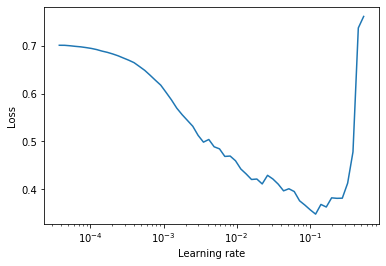

In [9]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(data_loader_train, end_lr=100, num_iter=100)
lr_finder.plot()

In [10]:
import time
import os
#i = 0
#train_csv_file = pd.read_csv(f'/mnt/disks/mount_point/train_splitted/train{i}.csv')

In [12]:
def training_model(i):
    
    train_dataset = IntracranialDataset(
        csv_file=f'/mnt/disks/mount_point/train_splitted/train{i}.csv', path='/mnt/disks/mount_point/stage_1_train_images_jpg', transform=transform_train, labels=True)
    print(f'/mnt/disks/mount_point/train_splitted/train{i}.csv')
    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    since = time.time()
    
    #checkpoint = torch.load('/mnt/disks/mount_point/train{i-1}.pth')
    #model.load_state_dict(checkpoint['model_state_dict'])
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == 'train':
                dataloader = data_loader_train
            else:
                dataloader = data_loader_valid
            for inputs, labels in dataloader:
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                dataset_size = len(train_dataset)
            else:
                dataset_size = len(valid_dataset)
            epoch_loss = running_loss / dataset_size
            #epoch_acc = running_corrects.double() / dataset_size

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
             #   phase, epoch_loss, epoch_acc))
            print(f'Loss: {epoch_loss}')

            # deep copy the model
            #if phase == 'val' :
             #   val_acc = epoch_acc
              #  print(f'val_acc: {val_acc}')
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), f'/mnt/disks/mount_point/train{i}.pth')
    return
    


In [13]:
for i in range(1):
    training_model(i)

/mnt/disks/mount_point/train_splitted/train0.csv
Epoch 0/0
----------


KeyboardInterrupt: 

In [1]:
!jupyter nbconvert --to python ongoing.ipynb

[NbConvertApp] Converting notebook ongoing.ipynb to python
[NbConvertApp] Writing 6677 bytes to ongoing.py


In [9]:
for i in range(1, 11):
    print(i)

1
2
3
4
5
6
7
8
9
10


In [59]:
ls /mnt/disks/mount_point/train_splitted/

train0.csv   train14.csv  train19.csv  train23.csv  train3.csv  train8.csv
train10.csv  train15.csv  train1.csv   train24.csv  train4.csv  train9.csv
train11.csv  train16.csv  train20.csv  train25.csv  train5.csv  valid.csv
train12.csv  train17.csv  train21.csv  train26.csv  train6.csv
train13.csv  train18.csv  train22.csv  train2.csv   train7.csv


In [58]:
!mv /mnt/disks/mount_point/train_splitted/df6 /mnt/disks/mount_point/train_splitted/train24.csv

In [60]:
ls /mnt/disks/mount_point/

backups/                           test.csv
checkpoints/                       train0.csv
copied_from_bootd/                 train12.csv
example.pth                        train16.csv
ipython_log.py                     train20.csv
lost+found/                        train20.pth
ongoing.ipynb                      train21.pth
process_csv.py                     train22.pth
rsna.ipynb                         train23.pth
rsna.py                            train24.csv
rsna_resnext.py                    train24.pth
sample.txt                         train25.pth
sometext.txt                       train26.pth
stage_1_sample_submission.csv      train4.csv
stage_1_sample_submission.csv.zip  train8.csv
stage_1_test_images_jpg/           train.csv
stage_1_train.csv                  train_splitted/
stage_1_train.csv.zip              trial.py
stage_1_train_images_jpg/          Untitled.ipynb
stderr.txt                         Untitled.py
stdout.txt                         valid.csv


In [5]:
!cp /mnt/disks/mount_point/train0.pth /mnt/disks/mount_point/backups

In [5]:
pd.read_csv('/mnt/disks/mount_point/valid.csv')

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_a81d35352,0,0,0,0,0,0
1,ID_6d4929f62,1,0,0,0,0,1
2,ID_8e1f5e5ee,0,0,0,0,0,0
3,ID_c5f68d242,0,0,0,0,0,0
4,ID_8b05d75f6,0,0,0,0,0,0
...,...,...,...,...,...,...,...
134847,ID_518c0608a,0,0,0,0,0,0
134848,ID_b3debf4a3,0,0,0,0,0,0
134849,ID_5fa900312,0,0,0,0,0,0
134850,ID_aabd4137e,0,0,0,0,0,0


In [28]:
tr0 = pd.read_csv('/mnt/disks/mount_point/train0.csv')

In [35]:
tr0

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_96492def9,0,0,0,0,0,0
1,ID_2bb5b7cb8,1,1,0,0,0,0
2,ID_626443765,0,0,0,0,0,0
3,ID_3496f44f7,1,0,0,0,0,1
4,ID_0504f4738,0,0,0,0,0,0
...,...,...,...,...,...,...,...
19995,ID_b93ad71b7,0,0,0,0,0,0
19996,ID_d8eb2cd68,0,0,0,0,0,0
19997,ID_aefe6fa3d,1,0,0,0,1,0
19998,ID_a3f66447d,0,0,0,0,0,0


In [29]:
tr4 = pd.read_csv('/mnt/disks/mount_point/train4.csv')

In [30]:
tr8 = pd.read_csv('/mnt/disks/mount_point/train8.csv')

In [31]:
tr12 = pd.read_csv('/mnt/disks/mount_point/train12.csv')

In [32]:
tr16 = pd.read_csv('/mnt/disks/mount_point/train16.csv')

In [33]:
tr20 = pd.read_csv('/mnt/disks/mount_point/train20.csv')

In [34]:
tr24 = pd.read_csv('/mnt/disks/mount_point/train24.csv')

In [37]:
newvalid = pd.concat([tr0, tr4, tr8, tr12, tr16, tr20, tr24])

In [38]:
newvalid.to_csv('/mnt/disks/mount_point/valid.csv', index=False)

In [40]:
pd.read_csv('/mnt/disks/mount_point/valid.csv')

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_96492def9,0,0,0,0,0,0
1,ID_2bb5b7cb8,1,1,0,0,0,0
2,ID_626443765,0,0,0,0,0,0
3,ID_3496f44f7,1,0,0,0,0,1
4,ID_0504f4738,0,0,0,0,0,0
...,...,...,...,...,...,...,...
139995,ID_6a1a5065e,1,0,0,0,1,0
139996,ID_57c54b888,0,0,0,0,0,0
139997,ID_38213fe3e,0,0,0,0,0,0
139998,ID_7087cbd7d,0,0,0,0,0,0


In [41]:
!rm /mnt/disks/mount_point/train2?.pth

rm: remove write-protected regular file '/mnt/disks/mount_point/train20.pth'? ^C


In [42]:
reader = pd.read_csv('/mnt/disks/mount_point/train_splitted/valid.csv', chunksize=20000)

In [43]:
for i, df in enumerate(reader):
    df.to_csv(f'/mnt/disks/mount_point/train_splitted/df{i}', index=False)

In [45]:
pd.read_csv('/mnt/disks/mount_point/train_splitted/df0')

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_a81d35352,0,0,0,0,0,0
1,ID_6d4929f62,1,0,0,0,0,1
2,ID_8e1f5e5ee,0,0,0,0,0,0
3,ID_c5f68d242,0,0,0,0,0,0
4,ID_8b05d75f6,0,0,0,0,0,0
...,...,...,...,...,...,...,...
19995,ID_f4f2fb9eb,1,0,0,0,1,0
19996,ID_03f9c4cfc,0,0,0,0,0,0
19997,ID_76b739440,0,0,0,0,0,0
19998,ID_3e9600341,0,0,0,0,0,0
